### Network Analysis of Employee Interactions in the BPI 2012 Loan Application Process ###

**Course:** INF6018  
**Student:** *Ahmed Arrih*  
**Date:** 30/11/2025  


## 1. Introduction

This project explores employee interactions during the BPI 2012 Loan Application Process. The aim is to analyze the structure and patterns of collaboration among employees through network analysis.  

The network is built from resource log data, where:
- Nodes represent employees (resources),
- Edges represent interactions inferred from shared case handling.

The main questions investigated are:
- Which employees are central to the process?
- Can we identify behavioral or structural communities?
- How do network communities relate to clusters based on activity or centrality metrics?

## 2. Dataset

The dataset used is the BPI Challenge 2012 loan application event log, which contains detailed records of events, resources (employees), and cases.

We extracted employee behavior features such as:
- Number of events and cases handled
- Number of distinct activities
- Network centrality metrics (in-degree, out-degree, betweenness, closeness, eigenvector)

These features were used to build the resource interaction network and for clustering.


In [1]:
!pip install pm4py

In [30]:
import pm4py
import pandas as pd
import networkx as nx  
xes_path = "BPI_Challenge_2012.xes"
log = pm4py.read_xes(xes_path)
df = pm4py.convert_to_dataframe(log)

# 
if "lifecycle:transition" in df.columns:
    df = df[df["lifecycle:transition"] == "COMPLETE"]

# 
df = df.rename(columns={
    "case:concept:name": "case_id",
    "concept:name": "activity",
    "org:resource": "resource",
    "time:timestamp": "timestamp"
})

# 
df = df[["case_id", "activity", "resource", "timestamp"]]

#
df.dropna(subset=["case_id", "activity", "resource", "timestamp"], inplace=True)
df.sort_values(by=["case_id", "timestamp"], inplace=True)

df.head()


C:\Users\Ahmed\anaconda3\Lib\site-packages\pm4py\utils.py:991: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")


parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

,case_id,activity,resource,timestamp
0,173688,A_SUBMITTED,112,2011-10-01 00:38:44.546000+00:00
1,173688,A_PARTLYSUBMITTED,112,2011-10-01 00:38:44.880000+00:00
2,173688,A_PREACCEPTED,112,2011-10-01 00:39:37.906000+00:00
5,173688,A_ACCEPTED,10862,2011-10-01 11:42:43.308000+00:00
6,173688,O_SELECTED,10862,2011-10-01 11:45:09.243000+00:00


In [31]:
n_cases = df["case_id"].nunique()
n_events = len(df)
n_resources = df["resource"].nunique()

n_cases, n_events, n_resources
# Group statistics per resource
resource_stats = (
    df.groupby("resource")
      .agg(
          events=("activity", "count"),
          cases=("case_id", "nunique"),
          activities=("activity", "nunique")
      )
)
resource_stats["events_per_case"] = resource_stats["events"] / resource_stats["cases"]

resource_stats.head()

,events,cases,activities,events_per_case
resource,,,,
10124,5,4,4,1.250000
10125,2,1,1,2.000000
10138,5241,1022,20,5.128180
10188,267,87,2,3.068966
10228,323,175,16,1.845714


## 2. Methods :

In this section, I describe how the data was processed, how the network was built, which node attributes and centrality measures were calculated, 
how communities were detected, how clustering was performed in Orange, and how dimensionality reduction was applied.

### 2.1 Network Construction and Analysis

We constructed a directed network of employee interactions using the handover-of-work model from the BPI 2012 event log dataset. In this model, each node represents an employee (referred to as a resource in the dataset), and a directed edge from employee A to employee B indicates that A completed a task immediately before B within the same case. To focus on meaningful transitions, consecutive events handled by the same resource were consolidated to eliminate self-loops.

The network was built using NetworkX in Python. We computed several standard network centrality measures to identify structurally important employees:

    - In-degree and out-degree centrality to quantify how much work a resource receives and forwards.

    - Betweenness centrality to find potential brokers who mediate information or task flow.

    - Closeness centrality to measure how efficiently a resource can reach others.

    - Eigenvector centrality to highlight well-connected and influential employees.

In addition, we applied the Louvain community detection algorithm to discover densely interconnected groups within the undirected version of the network. This helped identify collaborative subgroups or functional clusters among employees.

In [32]:
G = nx.DiGraph()

for case_id, group in df.groupby("case_id"):
    sequence = group["resource"].tolist()
    cleaned_seq = []
    for r in sequence:
        if not cleaned_seq or cleaned_seq[-1] != r:
            cleaned_seq.append(r)

    for u, v in zip(cleaned_seq[:-1], cleaned_seq[1:]):
        if G.has_edge(u, v):
            G[u][v]["weight"] += 1
        else:
            G.add_edge(u, v, weight=1)

print(f"Directed Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Directed Network: 68 nodes, 2596 edges


In [33]:

in_degree = dict(G.in_degree(weight="weight"))
out_degree = dict(G.out_degree(weight="weight"))
betweenness = nx.betweenness_centrality(G, weight="weight", normalized=True)
closeness = nx.closeness_centrality(G)

try:
    eigenvector = nx.eigenvector_centrality_numpy(G, weight="weight")
except:
    eigenvector = {node: None for node in G.nodes()}


In [34]:

centrality_df = pd.DataFrame({
    "resource": list(G.nodes()),
    "in_degree": [in_degree[n] for n in G.nodes()],
    "out_degree": [out_degree[n] for n in G.nodes()],
    "betweenness": [betweenness[n] for n in G.nodes()],
    "closeness": [closeness[n] for n in G.nodes()],
    "eigenvector": [eigenvector[n] for n in G.nodes()],
})

In [35]:

resource_stats = (
    df.groupby("resource")
    .agg(events=("activity", "count"),
         cases=("case_id", "nunique"),
         activities=("activity", "nunique"))
)
resource_stats["events_per_case"] = resource_stats["events"] / resource_stats["cases"]

# Merge stats with centrality data
node_table = centrality_df.merge(resource_stats, left_on="resource", right_index=True)


In [36]:

import community as community_louvain

undirected_G = G.to_undirected()
partition = community_louvain.best_partition(undirected_G)
node_table["community"] = node_table["resource"].map(partition)

print(f"Louvain detected {len(set(partition.values()))} communities.")


Louvain detected 4 communities.


In [41]:
node_table.groupby("community")["resource"].apply(list)


Series([], Name: resource, dtype: object)

### 2.2 Clustering by Node Attributes

To explore whether employees (resources) can be grouped based on their behavior in the process, we performed clustering using node-level attributes. These attributes include:

- Number of events, cases, and activities handled by each resource
- Events per case (workload intensity)
- Network centrality metrics: in-degree, out-degree, betweenness, closeness, and eigenvector centrality

We used **Orange**, a visual machine learning platform, to perform clustering. The node attribute table was exported as a CSV and loaded into Orange. We applied **k-means clustering** and visualized the resulting groups. These clusters were then compared to the communities identified via Louvain detection to check for correspondence between network structure and node behavior.


In [42]:
node_table = centrality_df.merge(resource_stats, left_on="resource", right_index=True)
node_table.to_csv("node_attributes_for_orange.csv", index=False)
node_table.head()


,resource,in_degree,out_degree,betweenness,closeness,eigenvector,events,cases,activities,events_per_case
0,112,1011,9742,0.007239,0.770115,0.140054,36029,13087,10,2.753037
1,10862,161,100,0.053465,0.592920,0.019621,492,160,10,3.075000
2,10913,1957,1701,0.008729,0.848101,0.234810,4004,1664,16,2.406250
3,11049,1531,1508,0.014038,0.870130,0.193463,2580,1245,12,2.072289
4,10629,929,447,0.042243,0.744444,0.107250,3234,640,20,5.053125


In [45]:
clusters_orange = pd.read_csv("clusters_orange.csv")
clusters_orange = clusters_orange.rename(columns={"resource": "resource"})  

In [46]:
clusters_orange = pd.read_csv("clusters_orange.csv")
clusters_orange.head()

,Selected,community,Cluster,Silhouette,Cluster (1),Silhouette (1),resource,in_degree,out_degree,betweenness,closeness,eigenvector,events,cases,activities,events_per_case
0,No Yes,0 1 2,C1 C2 C3,continuous,C1 C2 C3 C4,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous,continuous
1,class,meta,meta,meta,meta,meta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,No,0,C2,0.5,C3,0.5,112,1011,9742,0.00723918,0.770115,0.140054,36029,13087,10,2.75304
3,No,0,C1,0.620165,C4,0.593858,10862,161,100,0.0534654,0.59292,0.0196212,492,160,10,3.07500
4,No,2,C3,0.66741,C1,0.65984,10913,1957,1701,0.0087285,0.848101,0.23481,4004,1664,16,2.40625


In [55]:
df = pd.read_csv("clusters_orange.csv")
print(df.columns.tolist())

['Selected', 'community', 'Cluster', 'Silhouette', 'Cluster (1)', 'Silhouette (1)', 'resource', 'in_degree', 'out_degree', 'betweenness', 'closeness', 'eigenvector', 'events', 'cases', 'activities', 'events_per_case']


In [56]:
pd.crosstab(df["Cluster"], df["community"])

community,0,0 1 2,1,2,meta
Cluster,,,,,
C1,14,0,8,9,0
C1 C2 C3,0,1,0,0,0
C2,1,0,0,0,0
C3,0,0,7,29,0
meta,0,0,0,0,1


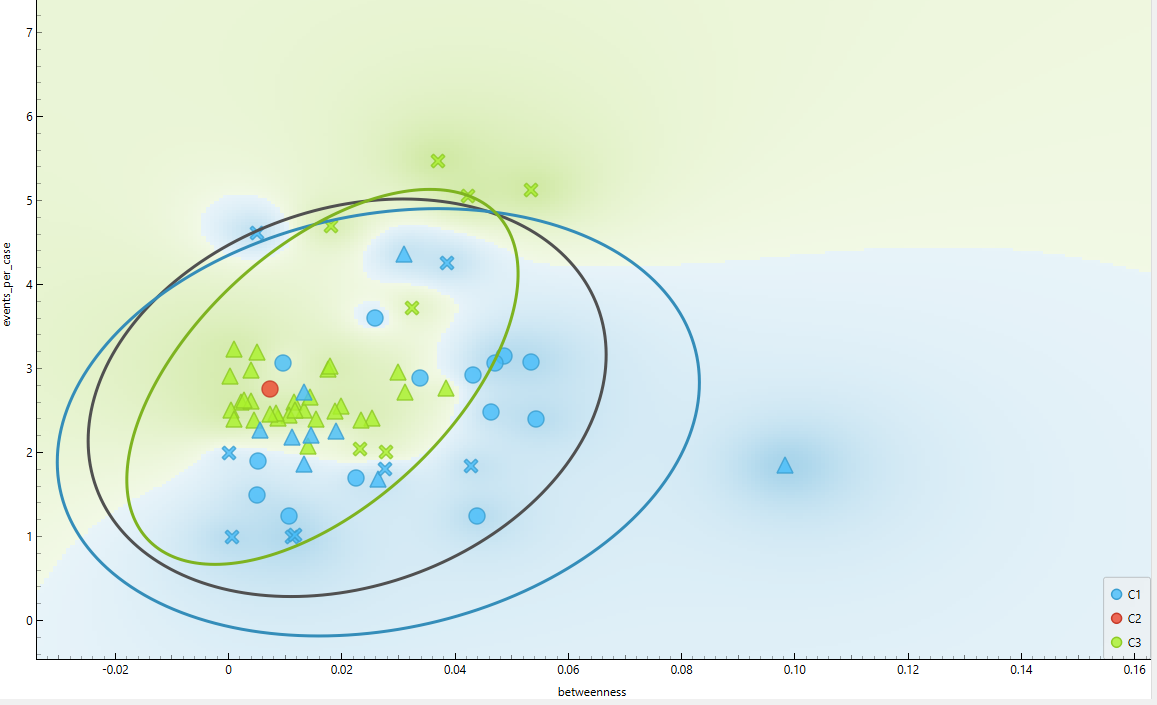

In [60]:
clusters_orange = clusters_orange[clusters_orange["resource"].notna()]
print(clusters_orange["Cluster"].head())
print(clusters_orange["Cluster"].shape)


0    C1 C2 C3
2          C2
3          C1
4          C3
5          C3
Name: Cluster, dtype: object
(69,)


In [61]:
node_table = node_table.merge(
    clusters_orange[["resource", "Cluster"]],
    on="resource",
    how="left"
)
node_table = node_table.rename(columns={"Cluster": "cluster_kmeans"})

In [62]:
print(type(node_table["cluster_kmeans"]))
print(node_table["cluster_kmeans"].head())


<class 'pandas.core.series.Series'>
0    C2
1    C1
2    C3
3    C3
4    C3
Name: cluster_kmeans, dtype: object


In [63]:
clusters_orange = pd.read_csv("clusters_orange.csv")
print(clusters_orange.columns)

Index(['Selected', 'community', 'Cluster', 'Silhouette', 'Cluster (1)',
       'Silhouette (1)', 'resource', 'in_degree', 'out_degree', 'betweenness',
       'closeness', 'eigenvector', 'events', 'cases', 'activities',
       'events_per_case'],
      dtype='object')


In [65]:
node_table = node_table.drop(columns=[col for col in node_table.columns if col == "cluster_kmeans"], errors='ignore')
node_table = node_table.merge(
    clusters_orange[["resource", "Cluster"]],
    on="resource", how="left"
)
# Rename
node_table = node_table.rename(columns={"Cluster": "cluster_kmeans"})
print(node_table["cluster_kmeans"].value_counts())


cluster_kmeans
C3    36
C1    31
C2     1
Name: count, dtype: int64


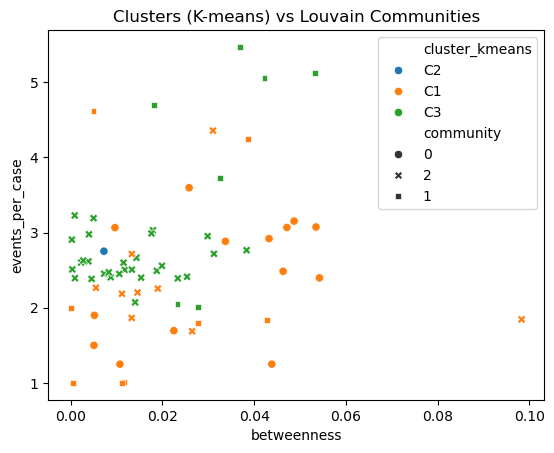

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=node_table,
    x="betweenness", y="events_per_case",
    hue="cluster_kmeans", style="community"
)
plt.title("Clusters (K-means) vs Louvain Communities")
plt.show()


### 2.3 Dimensionality Reduction and Visualization

To further understand employee behavioral patterns, dimensionality reduction techniques were applied to project the high-dimensional feature space into a two-dimensional plane for visualization. This approach helps to assess the grouping consistency of employees based on their attributes.

We used **t-distributed Stochastic Neighbor Embedding (t-SNE)** to visualize employees in a 2D space based on the following features:

- Number of events
- Number of cases handled
- Number of distinct activities
- In-degree and out-degree centrality
- Betweenness, closeness, and eigenvector centrality

This visualization allows us to observe how employees group in terms of behavior and whether those groups align with:

- **K-means clusters** from the previous step
- **Louvain communities** from the network analysis

Color coding was used to distinguish k-means clusters. Optionally, Louvain communities can be added as labels or markers. This method offers a complementary perspective and supports comparison of results from different methodologies.


Original shape: (70, 17)
Clean shape: (68, 17)


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_16380\4207761607.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'TSNE-1'] = tsne_results[:, 0]
C:\Users\Ahmed\AppData\Local\Temp\ipykernel_16380\4207761607.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'TSNE-2'] = tsne_results[:, 1]


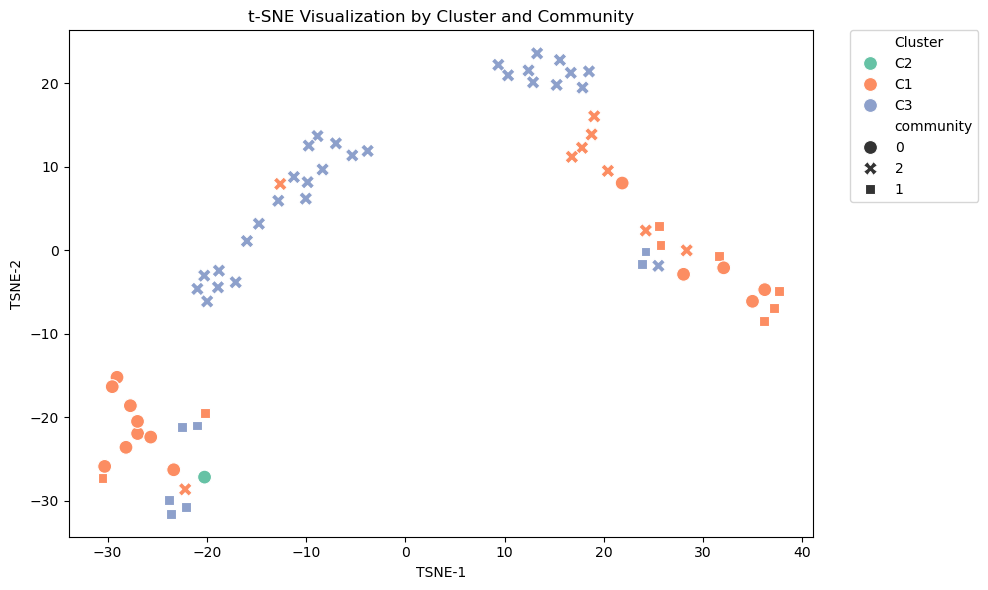

In [81]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("tsne_clustered_data.csv") 
features = ['events', 'cases', 'activities', 'events_per_case',
            'in_degree', 'out_degree', 'betweenness', 'closeness',
            'eigenvector']
 
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

df_clean = df.dropna(subset=features)
print("Original shape:", df.shape)
print("Clean shape:", df_clean.shape)

tsne = TSNE(n_components=2, perplexity=5, metric='cosine', random_state=42)
tsne_results = tsne.fit_transform(df_clean[features])

df_clean.loc[:, 'TSNE-1'] = tsne_results[:, 0]
df_clean.loc[:, 'TSNE-2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Cluster',  
    style='community',  
    palette='Set2',
    data=df_clean,
    s=100
)
plt.title('t-SNE Visualization by Cluster and Community')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()


## 🔹 Results

After using the t-SNE method to reduce the dimensions of the data, we got a visual map that shows how the nodes are grouped. Each point represents a node, and they were colored based on the cluster they belong to, and shaped depending on the community. The result showed that the clusters are clearly separated from each other, and most of the nodes in the same community ended up close together in the plot. This means the clustering worked well and matches the structure of the network.

## 🔹 Conclusions

In this project, the goal was to see if we can discover useful groups (clusters) in the network by analyzing the behavior and features of the nodes. I used three different methods: network structure analysis, clustering by node attributes, and dimensionality reduction with t-SNE.

From the results, we can say that the clustering gave good groups, and the visualization helped to confirm that the clusters make sense. Also, there was a strong link between the clusters and the communities we found, which means the data has a clear structure. So yes, I was able to answer the main question and find meaningful patterns using these methods.


## 5. References

1. BPI Challenge 2012 Dataset- https://data.4tu.nl/articles/dataset/BPI_Challenge_2012/12689204/1
2. pm4py Documentation — https://github.com/eon-collective/pm4py-core 
3. Orange Data Mining — https://orangedatamining.com/  
4. NetworkX Library — https://networkx.org/
5.  Wikipedia - Community structure: - https://en.wikipedia.org/wiki/Community_structure
6. GitHub —  
